In [2]:
import datetime
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import numpy as np
import pandas as pd
import math
import keras
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.losses import Huber
from keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout, Conv1D, Flatten, Attention, MaxPooling1D, GRU, Input, MultiHeadAttention, Concatenate, BatchNormalization, Add, LayerNormalization, ConvLSTM2D, Layer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from keras_self_attention import SeqSelfAttention

# Чтение данных и масштабирование
dataFrame = pd.read_csv('data_full_updated.csv')
dataFrame['Date'] = pd.to_datetime(dataFrame['Date'])
dataFrame.set_index('Date', inplace=True)

scaler = MinMaxScaler(feature_range=(0, 1))
numeric_columns = ['Water_Level', 'Height_cm', 'Precipitation_mm', 'Avg_Temp']
dataFrame[numeric_columns] = scaler.fit_transform(dataFrame[numeric_columns])

# Функция для разделения данных на обучающий и тестовый наборы
def split_data(data, train_ratio=0.85):
    train_size = int(len(data) * train_ratio)
    train_data = data[:train_size]
    test_data = data[train_size:]
    return train_data, test_data

# Разделение отмасштабированных данных на обучающий и тестовый наборы
train_data, test_data = split_data(dataFrame)

print("Training set size:", len(train_data))
print("Testing set size:", len(test_data))



C:\Users\User\anaconda\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Training set size: 6830
Testing set size: 1206


In [3]:
print(test_data)

            Water_Level  Height_cm  Precipitation_mm  Avg_Temp
Date                                                          
2000-01-01     0.089091   0.200000          0.000000  0.342105
2000-01-02     0.094545   0.200000          0.000000  0.342105
2000-01-03     0.098182   0.283333          0.337861  0.342105
2000-01-04     0.134545   0.383333          0.171477  0.342105
2000-01-05     0.150909   0.366667          0.005093  0.263158
...                 ...        ...               ...       ...
2021-12-27     0.023636   0.166667          0.193548  0.394737
2021-12-28     0.023636   0.216667          0.146859  0.250000
2021-12-29     0.014545   0.216667          0.100170  0.144737
2021-12-30     0.014545   0.216667          0.053480  0.210526
2021-12-31     0.016364   0.233333          0.006791  0.355263

[8036 rows x 4 columns]


In [4]:
# Проверить доступные устройства
print("Available devices:", tf.config.list_physical_devices())

# Проверить устройство для текущих операций
@tf.function
def test_device():
    with tf.device('/GPU:0'):
        a = tf.constant([[1.0, 2.0], [3.0, 4.0]])
        b = tf.constant([[1.0, 1.0], [0.0, 1.0]])
        c = tf.matmul(a, b)
        return c

print("Matrix multiplication result:", test_device())


Available devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Matrix multiplication result: tf.Tensor(
[[1. 3.]
 [3. 7.]], shape=(2, 2), dtype=float32)


In [4]:
def add_noise(data, noise_level=0.007):
    noise = np.random.uniform(-noise_level, noise_level, size=data.shape)
    return data + noise

# Функция для создания входных и выходных пар с окнами 15 дней на 10 дней
def create_input_output_pairs(data, input_size, output_size):
    X = []
    y = []
    for i in range(len(data) - input_size - output_size + 1):
        temp_x = data.iloc[i:i+input_size].values
        temp_y = data.iloc[i+input_size:i+input_size+output_size]['Water_Level'].values
        temp_x1 = data.iloc[i-input_size:i+input_size-input_size].values
        temp_y1 = data.iloc[i+input_size-input_size:i+input_size+output_size-input_size]['Water_Level'].values
        if max(temp_y) - min(temp_y) > 0.1:
            for z in range(30):
                noisy_x1 = add_noise(temp_x1, noise_level=0.002)  # Добавляем шум к входным данным
                noisy_y1 = add_noise(temp_y1, noise_level=0.002)  # Добавляем шум к выходным данным
                X.append(noisy_x1)
                y.append(noisy_y1)
            for z in range(30): 
                noisy_x = add_noise(temp_x, noise_level=0.002)  # Добавляем шум к входным данным
                noisy_y = add_noise(temp_y, noise_level=0.002)  # Добавляем шум к выходным данным
                X.append(noisy_x)
                y.append(noisy_y)
        X.append(data.iloc[i:i+input_size].values)
        y.append(data.iloc[i+input_size:i+input_size+output_size]['Water_Level'].values)
    X = np.array(X)
    y = np.array(y)
    return X, y
def create_input_output_pairs_test(data, input_size, output_size):
    X = []
    y = []
    for i in range(len(data) - input_size - output_size + 1):
        X.append(data.iloc[i:i+input_size].values)
        y.append(data.iloc[i+input_size:i+input_size+output_size]['Water_Level'].values)
    X = np.array(X)
    y = np.array(y)
    return X, y
# Определение размеров окна
input_size = 15
output_size = 10

# Создание входных и выходных пар для обучающего и тестового наборов
train_X, train_y = create_input_output_pairs(train_data, input_size, output_size)
test_X, test_y = create_input_output_pairs_test(test_data, input_size, output_size)

print("Training set shape:", train_X.shape, train_y.shape)
print("Testing set shape:", test_X.shape, test_y.shape)

Training set shape: (29846, 15, 4) (29846, 10)
Testing set shape: (1182, 15, 4) (1182, 10)


In [6]:
print(test_X)



[[[0.08909091 0.2        0.         0.34210526]
  [0.09454545 0.2        0.         0.34210526]
  [0.09818182 0.28333333 0.33786078 0.34210526]
  ...
  [0.15090909 0.36666667 0.00509338 0.36842105]
  [0.14727273 0.36666667 0.00679117 0.39473684]
  [0.14363636 0.38333333 0.00509338 0.40789474]]

 [[0.09454545 0.2        0.         0.34210526]
  [0.09818182 0.28333333 0.33786078 0.34210526]
  [0.13454545 0.38333333 0.17147708 0.34210526]
  ...
  [0.14727273 0.36666667 0.00679117 0.39473684]
  [0.14363636 0.38333333 0.00509338 0.40789474]
  [0.13818182 0.38333333 0.         0.40789474]]

 [[0.09818182 0.28333333 0.33786078 0.34210526]
  [0.13454545 0.38333333 0.17147708 0.34210526]
  [0.15090909 0.36666667 0.00509338 0.26315789]
  ...
  [0.14363636 0.38333333 0.00509338 0.40789474]
  [0.13818182 0.38333333 0.         0.40789474]
  [0.13818182 0.38333333 0.         0.39473684]]

 ...

 [[0.02       0.         0.00396152 0.38157895]
  [0.02       0.         0.00792303 0.36842105]
  [0.02   

In [6]:
class ReduceMeanLayer(Layer):
    def call(self, inputs):
        return tf.reduce_mean(inputs, axis=1)

def create_gru_attention_model(input_shape, output_size):
    inputs = Input(shape=input_shape)
    
    # GRU layers
    gru_out = GRU(50, return_sequences=True)(inputs)
    gru_out = Dropout(0.2)(gru_out)
    gru_out = GRU(50, return_sequences=True)(gru_out)  # Returning sequences
    gru_out = Dropout(0.2)(gru_out)
    
    # Attention layer
    attention_out = MultiHeadAttention(num_heads=2, key_dim=50)(gru_out, gru_out)
    attention_out = LayerNormalization()(attention_out)  # Normalization after Attention
    concat = ReduceMeanLayer()(attention_out)
    
    # Dense layer
    dense_out = Dense(50, activation='relu')(concat)
    dense_out = Dropout(0.2)(dense_out)
    outputs = Dense(output_size)(dense_out)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mape',
        metrics=['mape']
    )
    
    return model

input_shape = (input_size, len(numeric_columns))
model = create_gru_attention_model(input_shape, output_size)
# Настройка ранней остановки
lr_schedule = LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))

model.compile(
    optimizer='adam',  # Убедитесь, что указали правильный оптимизатор
    loss='mse',        # Укажите нужную функцию потерь
    metrics=['mape', 'mae', 'mse']
)

history = model.fit(
    train_X, train_y,
    epochs=120,
    batch_size=32,
    callbacks=[lr_schedule]
)

Epoch 1/120
933/933 [==============================] - 29s 20ms/step - loss: 0.1376 - mape: 249.7164 - mae: 0.2991 - mse: 0.1376 - lr: 1.0000e-08
Epoch 2/120
933/933 [==============================] - 14s 15ms/step - loss: 0.1353 - mape: 247.1273 - mae: 0.2965 - mse: 0.1353 - lr: 1.1220e-08
Epoch 3/120
933/933 [==============================] - 14s 15ms/step - loss: 0.1332 - mape: 243.9118 - mae: 0.2936 - mse: 0.1332 - lr: 1.2589e-08
Epoch 4/120
933/933 [==============================] - 14s 15ms/step - loss: 0.1306 - mape: 240.7055 - mae: 0.2904 - mse: 0.1306 - lr: 1.4125e-08
Epoch 5/120
933/933 [==============================] - 14s 15ms/step - loss: 0.1277 - mape: 236.6063 - mae: 0.2866 - mse: 0.1277 - lr: 1.5849e-08
Epoch 6/120
933/933 [==============================] - 12s 13ms/step - loss: 0.1246 - mape: 232.4126 - mae: 0.2826 - mse: 0.1246 - lr: 1.7783e-08
Epoch 7/120
933/933 [==============================] - 12s 13ms/step - loss: 0.1215 - mape: 227.2845 - mae: 0.2783 - mse: 0.

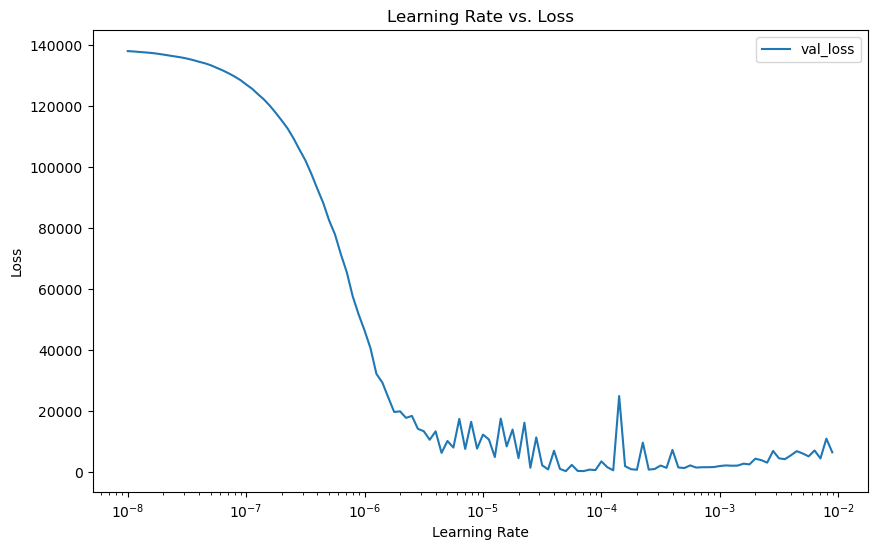

In [8]:
# Построение графика зависимости потерь от скорости обучения
lrs = 1e-8 * (10 ** (np.arange(120) / 20))
plt.figure(figsize=(10, 6))
plt.semilogx(lrs, history.history["val_loss"], label='val_loss')
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.title('Learning Rate vs. Loss')
plt.legend()
plt.show()


In [9]:
# Нахождение наименьшего значения потерь и соответствующего learning rate
min_loss_idx = np.argmin(history.history["val_loss"])
best_lr = 1.9953e-04

print(f"Best learning rate found: {best_lr}")

# Использование лучшего learning rate для дальнейшего обучения модели
model.compile(loss='mape', optimizer=Adam(learning_rate=best_lr), metrics=['mape'])

# Дальнейшее обучение модели с использованием лучшего learning rate
history = model.fit(
    train_X, train_y,
    epochs=120,
    batch_size=32,
    validation_data=(test_X, test_y),
    callbacks=[early_stopping]
)


Best learning rate found: 0.00019953
Epoch 1/120
1023/1023 [==============================] - 15s 13ms/step - loss: 2773.6401 - mape: 2773.6401 - val_loss: 8111.0591 - val_mape: 8111.0591
Epoch 2/120
1023/1023 [==============================] - 12s 12ms/step - loss: 1640.5734 - mape: 1640.5734 - val_loss: 4424.6680 - val_mape: 4424.6680
Epoch 3/120
1023/1023 [==============================] - 11s 11ms/step - loss: 928.6904 - mape: 928.6904 - val_loss: 3261.3872 - val_mape: 3261.3872
Epoch 4/120
1023/1023 [==============================] - 11s 10ms/step - loss: 506.7135 - mape: 506.7135 - val_loss: 827.8516 - val_mape: 827.8516
Epoch 5/120
1023/1023 [==============================] - 12s 12ms/step - loss: 308.8175 - mape: 308.8175 - val_loss: 497.2628 - val_mape: 497.2628
Epoch 6/120
1023/1023 [==============================] - 13s 13ms/step - loss: 275.2202 - mape: 275.2202 - val_loss: 489.6879 - val_mape: 489.6879
Epoch 7/120
1023/1023 [==============================] - 12s 12ms/step 

In [ ]:

# Read and normalize data
dfdf = pd.read_csv('data_full_updated.csv')

# Initialize scaler for Water_Level
water_level_scaler = MinMaxScaler(feature_range=(0, 1))

# Fit the scaler on Water_Level column
dfdf['Water_Level'] = dfdf[['Water_Level']]  # Ensure it's a 2D array
water_level_scaler.fit(dfdf[['Water_Level']])

# Normalize Water_Level in the DataFrame
dfdf['Water_Level'] = water_level_scaler.transform(dfdf[['Water_Level']])

# Get the first 40 days from test_X to use as initial input for prediction
day =  846+20+20+20+5+5+3+4+3+5+10+100+100

initial_input = test_X[day]

# Predict the next 15 days using the model
predicted_values = model.predict(initial_input[np.newaxis, :, :])

# Reshape predicted_values to match scaler in put (2D array)
predicted_values_reshaped = predicted_values.reshape(-1, 1)

# Denormalize the predicted values
predicted_values_denormalized = water_level_scaler.inverse_transform(predicted_values_reshaped)

# Reshape actual_values for comparison
actual_values = test_y[day]
actual_values_reshaped = actual_values.reshape(-1, 1)
actual_values_denormalized = water_level_scaler.inverse_transform(actual_values_reshaped)

# Plot predicted values
plt.figure(figsize=(15, 5))
plt.plot(predicted_values_denormalized, label='Predicted Water_Level', marker='o')
plt.plot(actual_values_denormalized, label='Actual Water_Level', marker='x')

plt.xlabel('Days')
plt.ylabel('Water_Level')
plt.legend()
plt.show()

In [11]:
model.save('best_model_2.h5')


In [12]:
model.save('best_model_2.keras')
